In [1]:
import matplotlib
import phonopy
import numpy as np
import API_phonopy as api_ph
import BTE_GreensFunction as BTEGF
import matplotlib.pyplot as plt
from matplotlib import cm, ticker 
from phonopy.units import VaspToTHz, EV, Angstrom, Kb, THz, THzToEv, Hbar
from scipy.interpolate import PchipInterpolator as pci
from scipy.interpolate import CubicSpline as cs
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm

In [2]:
Temperatures = [50,100,150,200,250,300]
Temperatures = np.array(Temperatures)
T_intp = np.linspace(np.min(Temperatures),np.max(Temperatures),21)


Lmin = 0.1
Lmax = 100

kmin = 2*np.pi/(Lmax*1e4) # in Angstrom^-1
kmax = 2*np.pi/(Lmin*1e4)

Nk = 101
kvec = np.logspace(np.log10(kmin),np.log10(kmax),Nk)
k_um = np.logspace(np.log10(1/Lmax),np.log10(1/Lmin),Nk)

Grating_um = np.logspace(np.log10(Lmin),np.log10(Lmax),201)
L_Angstrom = Grating_um*1e4
mesh = [24,24,10]#
Nrepeat_fc2 = [5,5,3] 

x_direct = [0] # this is a tuple/list object

# this doe sn't really matter. for calculations, as all velocities are input from BTE
poscar = 'POSCAR' 
sposcar_fc3 = '3RD.SPOSCAR'


is_isotope = True # include isotope
four_phonon = False # you will need to calculate 4ph scatterings 
write_data = True
D_boundary = 500e-6



In [3]:
# ----------------------------- Creating Phonon objects carrying BZ and qmesh ----------------------------------#
phonon = phonopy.load(unitcell_filename='POSCAR',
                      supercell_matrix=Nrepeat_fc2,
                      force_constants_filename='FORCE_CONSTANTS') # load with POSCAR and FORCE_SETS

fc2 = phonon.force_constants
phonon.run_mesh(mesh,is_gamma_center=True) 
# make gamma centered to be consistent with phono3py & ShengBTE

qpoints = phonon.get_mesh_dict()['qpoints']
w_qgrid = phonon.get_mesh_dict()['weights']
(Nqired,Ns) = phonon.get_mesh_dict()['frequencies'].shape #irreducible.
Wmat_grid = np.reshape(np.repeat(w_qgrid,Ns).T,(Nqired,Ns))
rots_qpoints = BTEGF.get_qpoint_rotsym(phonon) # rotations at q points.

In [4]:
alphaT = np.zeros(len(Temperatures))
v0T = np.zeros_like(alphaT)
etaT = np.zeros_like(alphaT)
gammaT = np.zeros_like(alphaT)
#kappaT = np.zeros_like(alphaT)


for iT,T0 in enumerate(Temperatures):
    # ------------------------------------- ShengBTE calculated phonon props -------------------------------------#
    BTE_Folder = './Qmesh-242410/'
    Dir_BTE_HarPhons = BTE_Folder+'BTE/' #remember to end with /
    Dir_BTE_lifetime = BTE_Folder + 'T' + str(T0) +'K/'
    Dir_BTE_MFD = BTE_Folder + 'T' + str(T0) +'K/' # set the same as RTA, then MFD is mean free path.
    # ------------------------------------ Params to calculate Callaway GF ---------------------------------------#
    
    qpoints_full,Vec_freqs,Vec_cqs,Vec_vqs,Vec_Fsc_qs,Vec_tau_qs,Vec_tauN_qs,Vec_tauR_qs,kappa_cvF,Nratio_qs = BTEGF.load_ShengBTE_Phonons(T0,phonon,Dir_BTE_HarPhons,Dir_BTE_MFD,Dir_BTE_lifetime,D_boundary,is_isotope,four_phonon)
    kappa_r = (kappa_cvF[0,0]+kappa_cvF[1,1])/2
    
    alpha_iT,v0_iT,eta_iT,gamma_iT = BTEGF.get_momentum_transCoeffs(kappa_cvF,Vec_cqs,Vec_vqs,Vec_freqs,Vec_tau_qs,Vec_tauR_qs, Nratio_qs,phonon,rots_qpoints)
    alphaT[iT] = alpha_iT
    v0T[iT] = v0_iT
    etaT[iT] = eta_iT
    gammaT[iT] = gamma_iT

    

    

/home/xinqian/Softwares/anaconda3/envs/phono3py/lib/python3.12/site-packages/phonopy/phonon/thermal_properties.py:64: RuntimeWarning: invalid value encountered in divide
  return Kb * x**2 * expVal / (expVal - 1.0) ** 2
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:564: RuntimeWarning: divide by zero encountered in divide
  tau_ph = 1./(scatt_rate_N+scatt_rate_U)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:565: RuntimeWarning: divide by zero encountered in divide
  tau_N = 1./scatt_rate_N # ps.
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:568: RuntimeWarning: divide by zero encountered in divide
  tau_qs = 1./(scatt_rate_N+scatt_rate_U+scatt_rate_I+scatt_rate_b)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:462: RuntimeWarning: invalid value encountered in scalar divide
  Vec_tau_sc[iqs] += Num/Den/weights[iq] # rescaled relaxatio time.
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:654: RuntimeWarning: divide by zero encoun

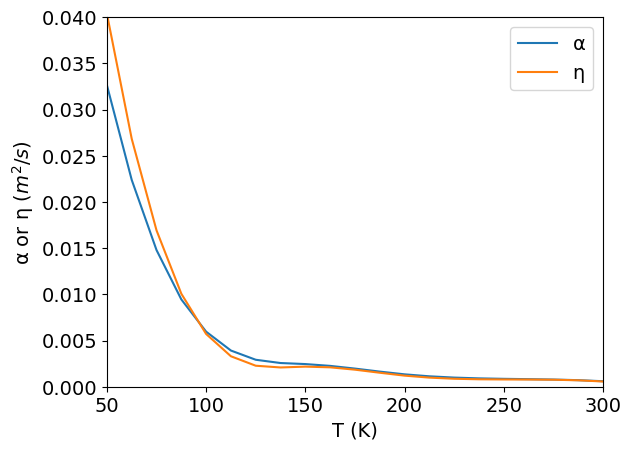

In [5]:
# Interpolate in temeperatures

falpha_intp = cs(Temperatures,alphaT)
fv0_intp = cs(Temperatures,v0T)
feta_intp = cs(Temperatures,etaT)
fgamma_intp = cs(Temperatures,gammaT)

alpha_intp = falpha_intp(T_intp)
v0_intp = fv0_intp(T_intp)
eta_intp = feta_intp(T_intp)
gamma_intp = fgamma_intp(T_intp)

plt.rcParams.update({'font.size': 14})
plt.plot(T_intp,alpha_intp*Angstrom**2*THz)
plt.plot(T_intp,eta_intp*Angstrom**2*THz)
plt.xlabel('T (K)')
plt.ylabel('α or η ($m^2/s$)')
plt.xlim([50,300])
plt.ylim([0,0.04])
plt.legend(['α','η'])

plt.savefig("Diffusivity_TP.svg",dpi=600,bbox_inches='tight',transparent=True)

<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_2470803/566155860.py:13: SyntaxWarning: invalid escape sequence '\g'
  ax2.set_ylabel('$\gamma$ (GHz)', color = color2)


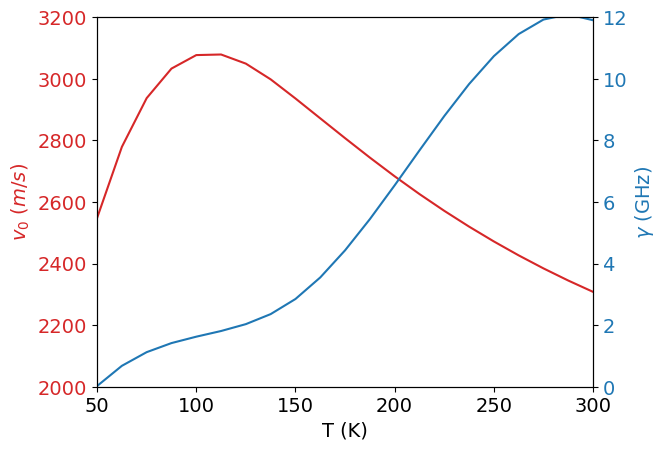

In [6]:
plt.rcParams.update({'font.size': 14})
fig, ax1 = plt.subplots() 
color1 = 'tab:red'
ax1.set_xlabel('T (K)') 
ax1.set_ylabel('$v_0$ ($m/s$)', color = color1) 
ax1.plot(T_intp,v0_intp*100, color = color1)
ax1.tick_params(axis ='y', labelcolor = color1) 
ax1.set_xlim([50,300])
ax1.set_ylim([2000,3200])
ax2 = ax1.twinx() 
color2 = 'tab:blue'

ax2.set_ylabel('$\gamma$ (GHz)', color = color2) 
ax2.plot(T_intp,gamma_intp*1000, color = color2)
ax2.tick_params(axis ='y', labelcolor = color2) 
ax2.set_ylim([0,12])

plt.savefig("Damping_v0.svg",dpi=600,bbox_inches='tight',transparent=True)

In [7]:
KK,TT = np.meshgrid(kvec,T_intp,indexing='ij')
KKum,TT = np.meshgrid(k_um,T_intp,indexing='ij')

In [8]:
OMEGA_P,OMEGA_M,vssT = BTEGF.get_secsound_dispersion(KK,alpha_intp,eta_intp,v0_intp,gamma_intp)

APT_sym = OMEGA_P.real==0

# find the first number become true.

kEP_um = gamma_intp/2/vssT*1e4/2/np.pi

cut_flag = kEP_um>np.min(KKum)
kEP =  kEP_um[cut_flag]
TEP = T_intp[cut_flag]

OMEGA_P_EP,OMEGA_M_EP,vssTEP = BTEGF.get_secsound_dispersion(gamma_intp/2/vssT,alpha_intp,eta_intp,v0_intp,gamma_intp)

Reomega_EP = OMEGA_P_EP[cut_flag].real
Imomega_EP = OMEGA_M_EP[cut_flag].imag

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2470803/166748125.py:10: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k/(2\pi)$ $(\mu m^{-1})$')
/tmp/ipykernel_2470803/166748125.py:12: SyntaxWarning: invalid escape sequence '\o'
  ax.set_zlabel('$Re[\omega]$ (GHz)')


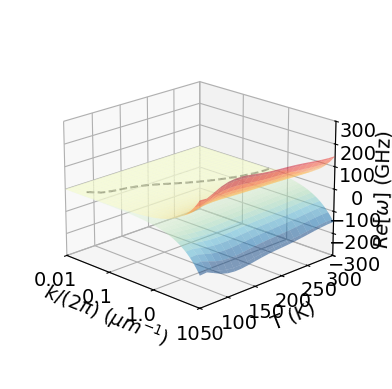

In [9]:
xticks = [0.01,0.1,1.0,10]

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
#ax.set_aspect('equal')
ax.plot(np.log10(kEP),TEP,Reomega_EP,'--',color='black')
ax.plot_surface(np.log10(KKum),TT,OMEGA_P.real*1e3,alpha=0.5,cmap='YlOrRd', vmin= 0, vmax=200)
ax.plot_surface(np.log10(KKum),TT,OMEGA_M.real*1e3,alpha=0.5,cmap='GnBu_r', vmin=-150, vmax=20)

#ax.s
ax.set_xlabel('$k/(2\pi)$ $(\mu m^{-1})$')
ax.set_ylabel('T (K)')
ax.set_zlabel('$Re[\omega]$ (GHz)')
ax.set_box_aspect(None, zoom=0.8)
ax.view_init(elev=20, azim=-45)

ax.set_xlim([np.log10(np.min(xticks)),np.log10(np.max(xticks))])
ax.set_ylim([np.min(Temperatures),np.max(Temperatures)])
ax.set_xticks(np.log10(xticks))
ax.set_xticklabels(xticks)
ax.set_zlim([-300,300])

plt.savefig("Re_omega.svg",dpi=600,bbox_inches='tight',transparent=True)

<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2470803/3504016638.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k/(2\pi)$ $(\mu m^{-1})$', fontsize=fontsize)
/tmp/ipykernel_2470803/3504016638.py:24: SyntaxWarning: invalid escape sequence '\o'
  ax.set_zlabel('$-Im[\omega]$ (GHz)', fontsize=fontsize)
/tmp/ipykernel_2470803/3504016638.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k/(2\pi)$ $(\mu m^{-1})$', fontsize=fontsize)
/tmp/ipykernel_2470803/3504016638.py:24: SyntaxWarning: invalid escape sequence '\o'
  ax.set_zlabel('$-Im[\omega]$ (GHz)', fontsize=fontsize)


TypeError: FigureCanvasSVG.print_svg() got an unexpected keyword argument 'wtransparent'

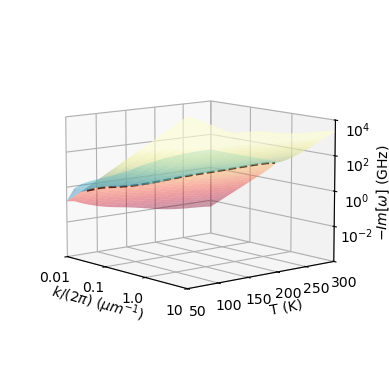

In [10]:
fontsize = 10
T_labels=[50,100,150,200,250,300]

powers_z = np.array([-4,-2,0,2,4])
zticks = 10.0**powers_z
zticks_label = []

for power in powers_z:
    label = '$10^{' +str(power)+'}$'
    zticks_label.append(label)

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((np.log10(zticks.min()), np.log10(zticks.max())))

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
#ax.set_aspect('equal')
ax.plot_surface(np.log10(KKum),TT,np.log10(-OMEGA_P.imag*1e3),alpha=0.4,cmap='YlOrRd_r', vmin=-2, vmax=3)
ax.plot_surface(np.log10(KKum),TT,np.log10(-OMEGA_M.imag*1e3),alpha=0.4,cmap='YlGnBu_r', vmin=-2, vmax=3)
#ax.plot(np.log10(k_APT),T_APT,np.log10(-omegaM_APT.imag*1e3),color='gray',alpha=0.2)
ax.plot(np.log10(kEP),TEP,np.log10(-Imomega_EP*1e3),'--',color='black')

ax.set_xlabel('$k/(2\pi)$ $(\mu m^{-1})$', fontsize=fontsize)
ax.set_ylabel('T (K)', fontsize=fontsize)
ax.set_zlabel('$-Im[\omega]$ (GHz)', fontsize=fontsize)
#ax.set_box_aspect(None, zoom=0.6)
ax.set_box_aspect(None, zoom=0.8)
ax.view_init(elev=10,azim=-40)

ax.set_xlim([np.log10(np.min(xticks)),np.log10(np.max(xticks))])
ax.set_xticks(np.log10(xticks))
ax.set_xticklabels(xticks, fontsize=fontsize)

ax.set_ylim([np.min(Temperatures),np.max(Temperatures)])
ax.set_yticks(T_labels)
ax.set_yticklabels(T_labels,fontsize=fontsize)


ax.set_zlim([np.log10(np.min(zticks)),np.log10(np.max(zticks))])
ax.set_zticks(np.log10(zticks[1:]))
ax.set_zticklabels(zticks_label[1:],fontsize=fontsize)
#ax.zaxis.set_label_position('lower')
#ax.zaxis.tick_right()
plt.savefig("Im_omega.svg",dpi=600,bbox_inches='tight',wtransparent=True)